In [218]:
from importlib import reload
import numpy as np
import folium
import src.localization as localization
reload(localization)
from src.localization import read_data
from src.localization import plot_coeffs
from src.localization import get_distance_in_meters
from src.localization import gen_regressors
from src.localization import gen_fingerprints
from src.localization import cell_search
from src.localization import result_map

1) Read Data
==
Read points and BTSs informations from CSV file

In [201]:
positions, df_points = read_data('resources/data/LocTreino_Equipe_2.csv')

In [202]:
bts_positions, df_btss = read_data('resources/data/dados_BTSs.csv')

## 1.1) Plot Original Points
Show the location of points and BTSs

In [203]:
# Calculate map center
center_lat = np.mean([lat for lat in bts_positions[:, 0]])
center_lon = np.mean([lon for lon in bts_positions[:, 1]])
original_pts_map = folium.Map(location=[center_lat, center_lon],
                              zoom_start=15,
                              tiles='CartoDB dark_matter')

In [204]:
# Plot points
for location in positions:
    marker = folium.CircleMarker(location=location,
                                 radius=1,
                                 color='blue',
                                 fill_opacity=0.1)
    marker.add_to(original_pts_map)

# Plot BTSs locations
for location in bts_positions:
    marker = folium.Marker(location=location)
    marker.add_to(original_pts_map)

# Export map
original_pts_map.save("resources/maps/original_pts_map.html")

# Show map
original_pts_map

2) Propagation Model
==
TODO: Choose a propagation model and replace the path loss with the output of the model

In [205]:
# ???

3) Fingerprint
==
Generate fingerprints for many cells to create a grid

## 3.1) Train Regressors
One regressor is trained for each BTS

In [206]:
# Path losses are the targets
# TODO: Replace path loss with output of propagation model
# Choose one of those?
# https://en.wikipedia.org/wiki/Radio_propagation_model
fingerprint_cols = ['pathBTS1',
                    'pathBTS2',
                    'pathBTS3',
                    'pathBTS4',
                    'pathBTS5',
                    'pathBTS6']
targets = [df_points[t_c] for t_c in fingerprint_cols]

# Input features
position_columns = ['lat', 'lon']
input_features = df_points[position_columns].values
regs = gen_regressors(input_features,
                      targets)

## 3.1) Generate Grid (with original positions and square grid cells)
A grid containing all the cells is generated. This is going to be consulted in the future

### 3.1.1) Add irregular cells
A cell is created for each point from the original training set

In [207]:
# Generate fingerprints for all samples
fingerprints = gen_fingerprints(input_features,
                                regs)
fingerprints = list(fingerprints)
cells = list(zip(list([list(x) for x in input_features]), fingerprints))

### 3.1.2) Add regular cells (this step may be skipped)
Additional cells are uniformly disposed in a rectagular grid

In [208]:
# Generate fingerprints for squared grid

# Calculate limits
lats = np.array(list(df_points['lat']))
lons = np.array(list(df_points['lon']))
max_lat = lats.max()
min_lat = lats.min()
max_lon = lons.max()
min_lon = lons.min()

# Add grid points
number_of_squares = 20
grid_lats = np.linspace(min_lat,
                        max_lat,
                        number_of_squares)
grid_lons = np.linspace(min_lon,
                        max_lon,
                        number_of_squares)
lat_centers = [(l1 + l2)/2 for l1, l2 in zip(grid_lats, grid_lats[1:])]
lon_centers = [(l1 + l2)/2 for l1, l2 in zip(grid_lons, grid_lons[1:])]

samples = []
for lat in lat_centers:
    for lon in lon_centers:
        samples.append((lat, lon))
cells += list(zip(samples, gen_fingerprints(samples, regs)))

## 3.2) Generate Grid Map

In [209]:
# Voronoi
from scipy.spatial import Voronoi
points = [(lat, lon) for (lat, lon), _ in cells]
vor = Voronoi(points)

# Create map
map_ = folium.Map(location=[center_lat, center_lon],
                 zoom_start=13,
                 tiles='CartoDB dark_matter')

# Add voronoi cells
for i1, i2 in vor.ridge_vertices:
    if i1 != -1 and i2 != -1:
        p1 = vor.vertices[i1]
        p2 = vor.vertices[i2]
        folium.PolyLine([p1, p2],
                        color='white',
                        weight=1,
                        opacity=0.2).add_to(map_)

# Add corners
corners = [[max_latitude, max_longitude],
           [max_latitude, min_longitude],
           [min_latitude, max_longitude],
           [min_latitude, min_longitude]]
for c in corners:
    marker = folium.Marker(location=c)
    marker.add_to(map_)

# Add grid points
for (lat, lon), _ in cells:
    marker = folium.CircleMarker(location=(lat,lon),
                                 color='blue',
                                 weight=2,
                                 radius=1,
                                 fill_color='blue',
                                 fill=True)
    marker.add_to(map_)
map_.save("resources/maps/grid.html")

4) Search
==
Find the corresponding cell given a fingerprint

## 4.1) Naive approach (sort)
For each test point, choose the cell with the closest (euclidean distance) fingerprint and save the result in a map.

In [ ]:
from IPython.display import clear_output

# Test with external data
positions, df_points = read_data('resources/data/LocTreino_Equipe_2.csv')

# Execute search for all points
pred_positions = []
for i, fingerprint in enumerate(list(df_points[target_columns].values)):
    clear_output(wait=True)
    print('Progress: ', float(i)/len(df_points))
    pred_pos, pred_fing = cell_search(fingerprint, cells)
    pred_positions.append(pred_pos)

In [187]:
# Generate result map
result_map(list(df_points[position_columns].values),
           pred_positions,
           "resources/maps/search_naive_result.html",
           only_show_error=True)

Map saved!


## 4.2) Using KNN classifier
For each test point, let the KNN classifier choose the cell

In [219]:
from sklearn.neighbors import KNeighborsClassifier

In [220]:
X_train = list([f for _, f in cells])
train_data_classes = range(len(X_train))
knn_squared_grid = KNeighborsClassifier(n_neighbors=1)
knn_squared_grid.fit(X_train, train_data_classes)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [227]:
# Test with external data
positions, df_points = read_data('resources/data/LocTreino_Equipe_2.csv')
fingerprints = df_points[df_points.columns[3:9]].values
cells_idxs = knn_squared_grid.predict(fingerprints)
pred_positions = [cells[i][0] for i in cells_idxs]

In [228]:
# Generate result map
result_map(list(df_points[position_columns].values),
           pred_positions,
           "resources/maps/search_KNN_result.html",
           only_show_error=True)

Map saved!


5) Statistics
==

In [229]:
error_in_meters = []
for (lat, lon), cell_idx in zip(list(df_points[df_points.columns[1:3]].values),
                                list(cells_idxs)):
    (pred_lat, pred_lon), _ = cells[cell_idx]
    error = get_distance_in_meters(lat, lon, pred_lat, pred_lon)
    error_in_meters.append(error)

In [230]:
print("Min Error (in meters):{}".format(np.min(error_in_meters)))
print("Max Error (in meters):{}".format(np.max(error_in_meters)))
print("Mean Error (in meters):{}".format(np.mean(error_in_meters)))
print("Std. Deviation (in meters):{}".format(np.std(error_in_meters)))

Min Error (in meters):0.0
Max Error (in meters):1817.2684709900884
Mean Error (in meters):54.07628261056796
Std. Deviation (in meters):127.49749484258561


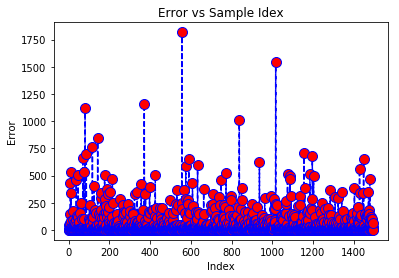

In [231]:
import matplotlib.pyplot as plt
plt.plot(range(len(error_in_meters)),
         error_in_meters,
         color='blue',
         linestyle='dashed',
         marker='o',
         markerfacecolor='red',
         markersize=10)
plt.title('Error vs Sample Idex')
plt.xlabel('Index')
plt.ylabel('Error')
plt.show()